Imports and Torch version

In [9]:
# IMPORTS
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as tfs
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd

print(torch.__version__)

2.1.0+cu118


Downloading MNIST Dataset

In [10]:
train_set = datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=tfs.Compose([tfs.ToTensor(), tfs.Normalize((0.5),(0.5))])
)

test_set = datasets.MNIST(
    root='./',
    train=False,
    download=True,
    transform=tfs.Compose([tfs.ToTensor(), tfs.Normalize((0.5),(0.5))])
)

Data Loaders and Training/Validation split

In [11]:
num_workers = 0
batch_size = 128
valid_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index , valid_index = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         num_workers=num_workers)

Exercise 1

In [12]:
# Gets the number of truue positives by comparing the predictions and labels
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


MLP Model

In [13]:
#Pytorch Neural Network library to build models

#MLP class extends nn.Module
#Base class for all neural network modules.
class MLP(nn.Module):
    # __init__ Initialise all layers in the NN model
    def __init__(self):
        super(MLP, self).__init__()
        # nn.Linear is a FC layer (Called Dense in keras)
        self.Input = nn.Linear(in_features=784,out_features=512)
        # nn.Dropout with drop rate p = 0.2 used to avoid overfitting 
        self.Dropout1 = nn.Dropout(0.2)
        self.Hidden = nn.Linear(in_features=512,out_features=512)
        self.Dropout2 = nn.Dropout(0.2)
        self.Predictions = nn.Linear(in_features=512,out_features=10)
    # forward is used to describe the behavior of the model during a feed forward pass
    def forward(self, input_tensor):
        #Flatten the w and h of the image (2D --> 1D)
        x = torch.flatten(input_tensor,start_dim=1)
        x = self.Input(x)
        #Apply non linear activation function relu
        x = F.relu(x)
        x = self.Dropout1(x)
        x = self.Hidden(x)
        x = F.relu(x)
        x = self.Dropout2(x)
        x = self.Predictions(x)
        #Apply Softmax to the output of the model then return the result
        x = F.softmax(x, dim=1)
        return x
    # __repr__ returns the models architecture when called
    def __repr__(self):
        return super().__repr__()

In [14]:
#Training the model
#Initializing an instance of MLP class
model = MLP()
#Specifying the optimizer that will be used to calculate the Backpropagation here RMSprop and specify the learning rate = 0.01
optimizer = optim.RMSprop(model.parameters(),lr=0.001)
#Initializing Tensorboard to store scalars in the specified directory
writer = SummaryWriter(log_dir='/mnt/d/VSCode/TD_Systèmes_Intelligents_Avancés/Results/MLP/')
# number of epochs to train the model
n_epochs = 20
# Iterate through the entire dataset based on the number of epochs specified
for epoch in range(n_epochs):
    #Initialize scalar values to 0 at each epoch
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    #Changing model state to train 
    model.train()
    for batch in train_loader: #Get batch
        images, labels = batch
        #Sets the gradients of all optimized torch.Tensors to zero.
        optimizer.zero_grad()
        preds = model(images) # Pass or forward batch
        loss = F.cross_entropy(preds, labels) # Calculate loss using cross entropy multiclass
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights
        #Add batch loss value to train loss (We want the mean)
        train_loss += loss.item() * images.size(0)
        #Add batch TP (True Positive) value to train correct (We want the mean Accuracy)
        train_correct += get_num_correct(preds, labels) 
    model.eval()
    #Get batch from validation set
    for batch in valid_loader:
        images, labels = batch
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        val_loss = loss.item() * images.size(0)
        val_correct += get_num_correct(preds, labels) 
    #Calculating the epochs values for loss acc val_loss and val_accuracy
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(valid_loader.sampler)
    accuracy = train_correct / len(train_loader.sampler)
    val_accuracy = val_correct / len(valid_loader.sampler)
    #Adding these scalars to tensorboard usinf add_scalar function
    writer.add_scalar('Loss/loss', train_loss, epoch+1)
    writer.add_scalar('Loss/val_loss', val_loss, epoch+1)
    writer.add_scalar('Accuracy/acc', accuracy, epoch+1)
    writer.add_scalar('Accuracy/val_acc', val_accuracy, epoch+1)
    #Shawing the epochs scalar values
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss,
        accuracy,
        val_accuracy
        ))
#Closing the writer at the end of training
writer.close()

Epoch: 1 	Training Loss: 2.371415 	Validation Loss: 0.018856 	Accuracy: 0.089542 	Validation Accuracy: 0.093000
Epoch: 2 	Training Loss: 2.371463 	Validation Loss: 0.018773 	Accuracy: 0.089688 	Validation Accuracy: 0.093000
Epoch: 3 	Training Loss: 2.371463 	Validation Loss: 0.019273 	Accuracy: 0.089688 	Validation Accuracy: 0.093000
Epoch: 4 	Training Loss: 2.371463 	Validation Loss: 0.019106 	Accuracy: 0.089688 	Validation Accuracy: 0.093000
Epoch: 5 	Training Loss: 2.371463 	Validation Loss: 0.018939 	Accuracy: 0.089688 	Validation Accuracy: 0.093000
Epoch: 6 	Training Loss: 2.371463 	Validation Loss: 0.018856 	Accuracy: 0.089688 	Validation Accuracy: 0.093000
Epoch: 7 	Training Loss: 2.371463 	Validation Loss: 0.018773 	Accuracy: 0.089688 	Validation Accuracy: 0.093000
Epoch: 8 	Training Loss: 2.371463 	Validation Loss: 0.019189 	Accuracy: 0.089688 	Validation Accuracy: 0.093000
Epoch: 9 	Training Loss: 2.371463 	Validation Loss: 0.018773 	Accuracy: 0.089688 	Validation Accuracy: 0

Matrice de Confusion:

In [15]:
# IMPORTS
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Evaluating the resulting model the nconstructing the Confusion Matrix

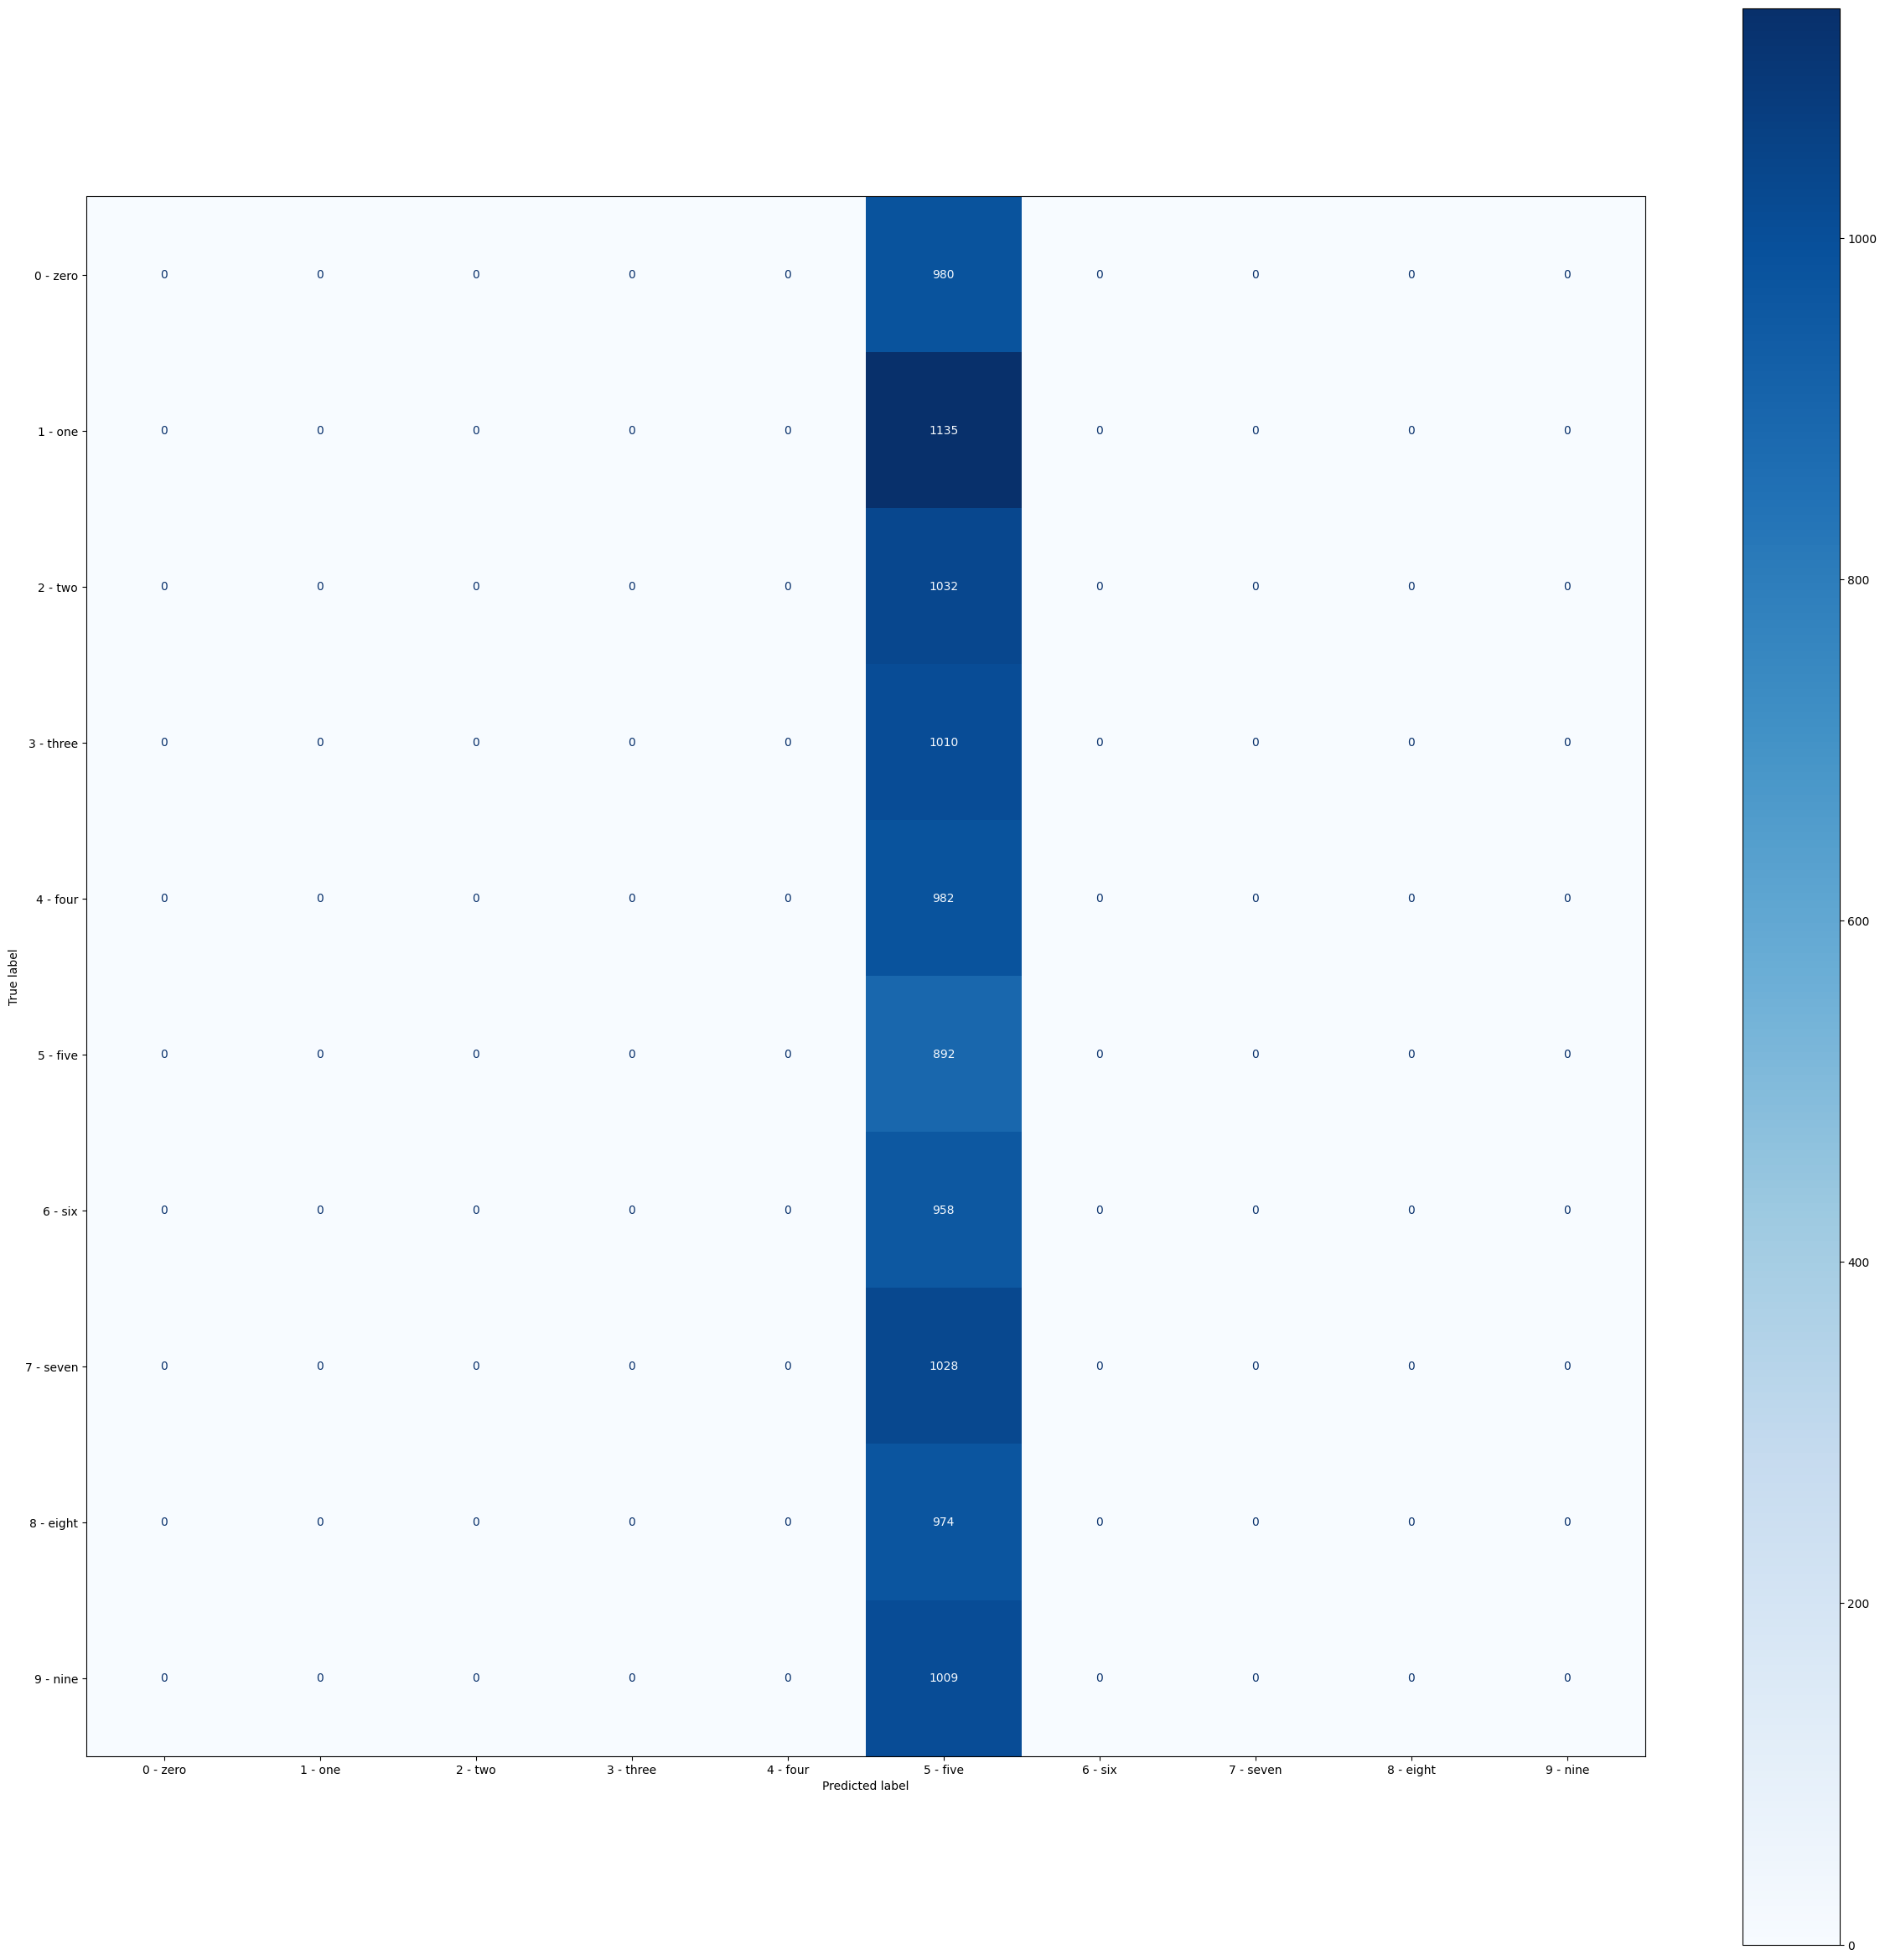

Test Loss: 2.371951

Test Accuracy of     0:  0% ( 0/980)
Test Accuracy of     1:  0% ( 0/1135)
Test Accuracy of     2:  0% ( 0/1032)
Test Accuracy of     3:  0% ( 0/1010)
Test Accuracy of     4:  0% ( 0/982)
Test Accuracy of     5: 100% (892/892)
Test Accuracy of     6:  0% ( 0/958)
Test Accuracy of     7:  0% ( 0/1028)
Test Accuracy of     8:  0% ( 0/974)
Test Accuracy of     9:  0% ( 0/1009)


In [16]:
# Initialize lists to monitor test loss and accuracy
y_pred = []
y_tr = []
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # This prepares the model for evaluation
for batch in test_loader:
    images, labels = batch
    preds = model(images)
    y_pred.extend(np.argmax(preds.detach().numpy(), axis=1))
    y_tr.extend(labels.detach().numpy().tolist())
    loss = F.cross_entropy(preds,labels) # Calculate loss
    test_loss += loss.item() * images.size(0) # update test loss
    _, pred = torch.max(preds, 1) # Convert output probabilities to predicted class
    correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # Compare predictions to true label
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

cm = confusion_matrix(y_true=y_tr, y_pred=y_pred)
lbls = test_set.classes
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
fig,ax = plt.subplots(figsize=(30,30))
cmp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))